# Understanding GFS Data


**Attribution:** This notebook uses weather data from the National Oceanic and Atmospheric Administration (NOAA) Global Forecast System (GFS), accessed via the AWS Registry of Open Data.

[NOAA Site](https://www.noaa.gov/)

In [1]:
# Import the following packages
import os
from IPython.display import Image
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import pandas as pd
import numpy as np
import cfgrib
import pygrib
import zarr
import fsspec
import matplotlib.pyplot as plt

In [3]:
# Utility function to get the absolute path to a resource
def get_resource_path(relative_path):
    """Get absolute path to resource"""
    notebook_dir = os.getcwd()  # current working directory of the notebook
    return os.path.join(notebook_dir, 'resources', relative_path)

### Terminology:
- NWP (Numerical Weather Prediction). The use of mathematical models to simulate atmospheric processes and predict future weather conditions.
- GFS (Global Forecast System). A global NWP model produced by the National Centers for Environmental Prediction (NCEP), a part of the National Oceanic and Atmospheric Administration (NOAA). It provides weather forecasts up to 16 days in advance.
  - [GFS Documentation](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)

### You can access the GFS data on AWS Registry of Open Data
The entire globe is covered by the GFS at a base horizontal resolution of 18 miles (28 kilometers/0.25 degree grid) between grid points, which is used by the operational forecasters who predict weather out to 7 days in the future. Horizontal resolution drops to 44 miles (70 kilometers) between grid point for forecasts between one week and two weeks (16 days). It is updated 4 times a day, every 6 hours starting at midnight UTC
[AWS Open Data Link](https://registry.opendata.aws/noaa-gfs-bdp-pds/)

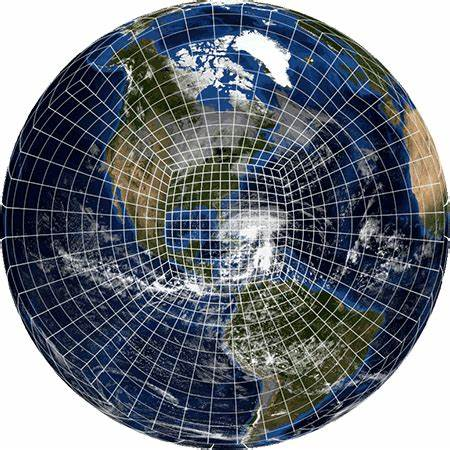

In [4]:
image_path = get_resource_path('images/gfs_grid.jpeg')
Image(filename=image_path, width=300)

The commands below assume aws cli access
[AWS CLI](https://aws.amazon.com/cli/)

In [ ]:
# To look at the data found in a folder on Jan 01, 2021 00 forecast
!aws s3 ls --no-sign-request s3://noaa-gfs-bdp-pds/gfs.20210101/00/
# You will notice folders like:
# 2024-04-16 02:34:31  110636906 gfs.t00z.sfluxgrbf000.grib2
# 2024-04-16 02:34:35       2675 gfs.t00z.sfluxgrbf000.grib2.idx (metadata)
# sfluxgrbf000 - surface flux grib forecast files
# Covering forecast hours from f000 (analysis/initial time) to f384 (16 days out; 24 hrx x 16 days = 384)

In [7]:
# Download the GFS surface flux file to your local machine
!aws s3 cp --no-sign-request s3://noaa-gfs-bdp-pds/gfs.20210101/00/gfs.t00z.sfluxgrbf012.grib2 ./gfs.t00z.sfluxgrbf012.grib2

download: s3://noaa-gfs-bdp-pds/gfs.20210101/00/gfs.t00z.sfluxgrbf012.grib2 to ./gfs.t00z.sfluxgrbf012.grib2


In [8]:
# Use pygrib to look at the data
# Open the GRIB2 file
with pygrib.open('gfs.t00z.sfluxgrbf012.grib2') as grbs:
    for grb in grbs:
        print(grb)

1:Geopotential height:gpm (instant):regular_gg:hybrid:level 1:fcst time 12 hrs:from 202101010000
2:Temperature:K (instant):regular_gg:hybrid:level 1:fcst time 12 hrs:from 202101010000
3:Specific humidity:kg kg**-1 (instant):regular_gg:hybrid:level 1:fcst time 12 hrs:from 202101010000
4:U component of wind:m s**-1 (instant):regular_gg:hybrid:level 1:fcst time 12 hrs:from 202101010000
5:V component of wind:m s**-1 (instant):regular_gg:hybrid:level 1:fcst time 12 hrs:from 202101010000
6:Surface pressure:Pa (instant):regular_gg:surface:level 0:fcst time 12 hrs:from 202101010000
7:Orography:m (instant):regular_gg:surface:level 0:fcst time 12 hrs:from 202101010000
8:Temperature:K (instant):regular_gg:surface:level 0:fcst time 12 hrs:from 202101010000
9:Soil temperature:K (instant):regular_gg:depthBelowLandLayer:levels 0.0-0.1 m:fcst time 12 hrs:from 202101010000
10:Volumetric soil moisture content:Proportion (instant):regular_gg:depthBelowLandLayer:levels 0.0-0.1 m:fcst time 12 hrs:from 2021

In [9]:
# The downward short-wave radiation flux (DSWRF) represents solar irradiance
# in watts per square meter (W/m²) from 300 to 4000 nm (nanometers) at the Earth's surface
# Let's get the DSWRF values

with pygrib.open('gfs.t00z.sfluxgrbf012.grib2') as grbs:
    for grb in grbs:
        if 'Downward short-wave radiation flux' in str(grb):
            print(f"Found DSWRF: {grb}")
            dswrf_data = grb.values
            lats, lons = grb.latlons()
            print(f"Data shape: {dswrf_data.shape}")
            print(f"Lat range: {lats.min()}, {lats.max()}")
            print(f"Lon range: {lons.min()}, {lons.max()}")
            print(f"Units: {grb.parameterUnits}")
            print(f"Min DSWRF: {dswrf_data.min()} W/m², Max DSWRF: {dswrf_data.max()} W/m²")
            print("------------")

Found DSWRF: 88:Downward short-wave radiation flux:W m**-2 (avg):regular_gg:surface:level 0:fcst time 6-12 hrs (avg):from 202101010000
Data shape: (1536, 3072)
Lat range: -89.91032453466268, 89.91032453466268
Lon range: 0.0, 359.882813
Units: 192
Min DSWRF: 0.0 W/m², Max DSWRF: 1040.0 W/m²
------------
Found DSWRF: 96:Downward short-wave radiation flux:W m**-2 (instant):regular_gg:surface:level 0:fcst time 12 hrs:from 202101010000
Data shape: (1536, 3072)
Lat range: -89.91032453466268, 89.91032453466268
Lon range: 0.0, 359.882813
Units: 192
Min DSWRF: 0.0 W/m², Max DSWRF: 1130.0 W/m²
------------
Found DSWRF: 103:Downward short-wave radiation flux:W m**-2 (avg):regular_gg:nominalTop:level 0:fcst time 6-12 hrs (avg):from 202101010000
Data shape: (1536, 3072)
Lat range: -89.91032453466268, 89.91032453466268
Lon range: 0.0, 359.882813
Units: 192
Min DSWRF: 0.0 W/m², Max DSWRF: 1290.0 W/m²
------------


### Understanding the short-wave radiation flux data
- Variable 88: DSWRF (avg, surface, 6-12 hrs): Represents the average solar irradiance over the 6-hour period leading to 12:00 UTC. Useful for aggregated analysis but less precise for instantaneous conditions.
- Variable 96: DSWRF (instant, surface, 12 hrs): Represents solar irradiance at a specific moment (12:00 UTC). Best for analyzing conditions at that exact time, such as daytime solar potential at specific locations.
- Variable 103: DSWRF (avg, nominalTop, 6-12 hrs): Represents solar radiation at the top of the atmosphere, not accounting for surface effects (e.g., clouds, terrain). Less relevant for surface solar irradiance analysis.

### The grib2 file has over 100 variables. This is not the best tool for the job of analysis, it is better to use xarray that is better at handling multi-dimensional arrays. Also, let's filter for the surface with average step type.

There are different stepTypes:
- instant: 	Value at a specific forecast time (e.g., temperature at hour 12)
- avg: Average over the time range (e.g., radiation averaged over hours 6–12)
- accum: Accumulated total over the time range (e.g., precipitation total between 6–12 hrs)

We want to use `avg` stepType for scenarios where a measurement builds up or fluctuates.

In [10]:
type_of_level = "surface"
step_type = "avg"

ds = xr.open_dataset(
    "gfs.t00z.sfluxgrbf012.grib2",
    engine="cfgrib",
    filter_by_keys={"typeOfLevel": type_of_level, "stepType": step_type}
)

In [11]:
print(ds)

<xarray.Dataset> Size: 585MB
Dimensions:     (latitude: 1536, longitude: 3072)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 12kB 89.91 89.79 89.68 ... -89.79 -89.91
  * longitude   (longitude) float64 25kB 0.0 0.1172 0.2344 ... 359.6 359.8 359.9
    valid_time  datetime64[ns] 8B ...
Data variables: (12/31)
    snowc       (latitude, longitude) float32 19MB ...
    evcw        (latitude, longitude) float32 19MB ...
    evbs        (latitude, longitude) float32 19MB ...
    trans       (latitude, longitude) float32 19MB ...
    sbsno       (latitude, longitude) float32 19MB ...
    cpr         (latitude, longitude) float32 19MB ...
    ...          ...
    csulf       (latitude, longitude) float32 19MB ...
    vbdsf       (latitude, longitude) float32 19MB ...
    vddsf       (latitude, longitude) float32 19MB ...
    nbdsf       (latitude, longitude) float32 19MB ...
    nddsf 

# Some of these acronyms are very cryptic. Here is a table that explains their meaning
https://www.nco.ncep.noaa.gov/pmb/docs/grib2/grib2_doc/grib2_table4-2-0-4.shtml

# Solar Flux Table:

VBDSF: Visible Beam Downward Solar Flux

VDDSF: Visible Diffuse Downward Solar Flux

NBDSF: Near IR Beam Downward Solar Flux

NDDSF: Near IR Diffuse Downward Solar Flux

CSULF: Clear Sky Upward Longwave Flux

CSUSF: Clear Sky Upward Solar Flux

CSDSF: Clear Sky Downward Shortwave Flux

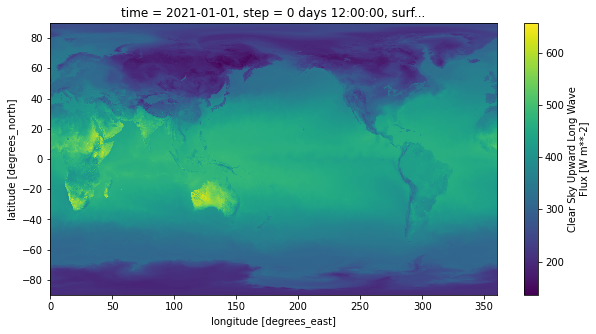

In [12]:
#csulf has a good visual of the Earth and the various irradiance levels
ds['csulf'].plot(x='longitude', y='latitude', figsize=(10, 5))

In [13]:
# To get GHI (Global Horizontal Irradiance)
ghi = ds['vbdsf'] + ds['vddsf'] + ds['nbdsf'] + ds['nddsf']

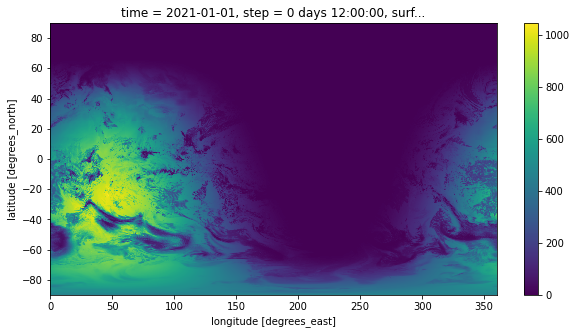

In [14]:
ghi.plot(x='longitude', y='latitude', figsize=(10, 5))

### Zarr stores large multi-dimensional arrays in a compact and efficient format, ideal for quick access and analysis in xarray.

Let's look at a gfs zarr file from OCF

In [15]:
!aws s3 ls --no-sign-request s3://ocf-open-data-pvnet/data/gfs.zarr/

                           PRE dlwrf/
                           PRE dswrf/
                           PRE hcc/
                           PRE init_time_utc/
                           PRE latitude/
                           PRE lcc/
                           PRE longitude/
                           PRE mcc/
                           PRE prate/
                           PRE r/
                           PRE sde/
                           PRE step/
                           PRE t/
                           PRE tcc/
                           PRE u10/
                           PRE u100/
                           PRE v10/
                           PRE v100/
                           PRE vis/
2025-01-13 07:08:29        636 .zattrs
2025-01-13 07:08:29         24 .zgroup
2025-01-13 07:08:29      40097 .zmetadata


In [16]:
# Let's convert the zarr file to a dataset using xarray
store = fsspec.get_mapper("s3://ocf-open-data-pvnet/data/gfs.zarr/", anon=True)
ds = xr.open_zarr(store, consolidated=True)

In [17]:
print(ds)

<xarray.Dataset> Size: 667MB
Dimensions:        (init_time_utc: 1415, step: 17, latitude: 21, longitude: 22)
Coordinates:
  * init_time_utc  (init_time_utc) datetime64[ns] 11kB 2023-01-01 ... 2023-12...
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 176B 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 10.0
  * step           (step) timedelta64[ns] 136B 0 days 00:00:00 ... 2 days 00:...
Data variables: (12/15)
    dlwrf          (init_time_utc, step, latitude, longitude) float32 44MB dask.array<chunksize=(1415, 4, 1, 1), meta=np.ndarray>
    dswrf          (init_time_utc, step, latitude, longitude) float32 44MB dask.array<chunksize=(1415, 4, 1, 1), meta=np.ndarray>
    hcc            (init_time_utc, step, latitude, longitude) float32 44MB dask.array<chunksize=(1415, 4, 1, 1), meta=np.ndarray>
    lcc            (init_time_utc, step, latitude, longitude) float32 44MB dask.array<chunksize=(1415, 4, 1, 1), meta=np.ndarray>
    mcc       

<hr>

## Explanations of the zarr, gfs file components using xarray:
📐 **Dimensions**

`init_time_utc`: The model run start time (also called initialization time).

`step`: The forecast offset from the init time (like +0h, +6h, +12h, etc).

These are the forecast horizons for each run.

`latitude` and `longitude`: The spatial grid.

This dataset has 21 latitudes and 22 longitudes.

📊 **Data Variables**

Each variable is 4D: (`init_time_utc, step, latitude, longitude`). Some key variables:

`dswrf` – Downward shortwave radiation flux: solar energy reaching the surface (used to compute GHI).

`dlwrf` – Downward longwave radiation flux: infrared heat from the atmosphere.

`u10`, `v10` – Wind components at 10 meters above the surface.

`tcc`, `hcc`, `mcc`, `lcc` – Total, high, middle, and low cloud cover.

`prate` – Precipitation rate.

`vis` – Visibility.

`t` – Temperature at some vertical level (often surface or 2m).

⚡ **Attributes**

The metadata includes:

`institution`: Where the data came from (e.g. NOAA).

`model`: The forecast model (GFS).

`description`: A human-readable label.

`product`: The GRIB product type (e.g., pgrb2.1p00 means 1.0° resolution).

## The United Kingdom's latitude and longitude range is approximately:

Latitude: 49°N to 61°N

Longitude: 9°W to 2°E

This covers the main islands, including England, Scotland, Wales, Northern Ireland, and some outlying islands like the Shetlands and Channel Islands.

In [18]:
# As you can see, this zarr file contains the UK's lat's and lon's
print("Lat range:", ds.latitude.values.min(), "to", ds.latitude.values.max())
print("Lon range:", ds.longitude.values.min(), "to", ds.longitude.values.max())

Lat range: 45.0 to 65.0
Lon range: 0.0 to 10.0


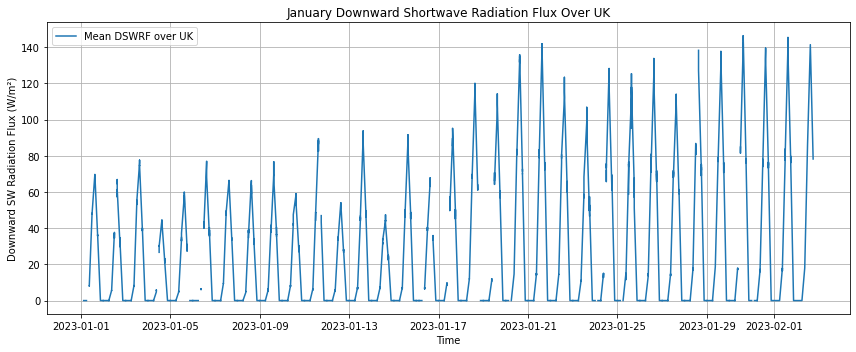

In [19]:
# 1. Filter to just January
january = ds.sel(init_time_utc=ds.init_time_utc.dt.month == 1)

# 2. Average over lat/lon for each forecast step and model run
# Resulting shape: (init_time_utc, step)
dswrf_mean = january['dswrf'].mean(dim=["latitude", "longitude"])

# 3. Convert to DataFrame for line plotting
# Combine init time and step to get actual forecast time
forecast_time = dswrf_mean.init_time_utc.values[:, None] + dswrf_mean.step.values[None, :]
forecast_time_flat = forecast_time.flatten()
dswrf_flat = dswrf_mean.values.flatten()

df = pd.DataFrame({
    "forecast_time": forecast_time_flat,
    "dswrf": dswrf_flat
})

# 4. Sort by forecast_time and plot
df = df.sort_values("forecast_time")

plt.figure(figsize=(12, 5))
plt.plot(df["forecast_time"], df["dswrf"], label="Mean DSWRF over UK")
plt.xlabel("Time")
plt.ylabel("Downward SW Radiation Flux (W/m²)")
plt.title("January Downward Shortwave Radiation Flux Over UK")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

With these examples, you should have learned a bit about the GFS and NWP data
as well as the tool you can use for the OCF open-data-pvnet project. Now your turn to explore
further the dataset...